***Vorlesung 'Syntax natürlicher Sprachen'***

--- 
# Vorlesung 13: Partielles Parsing


In [1]:
import nltk
from nltk.corpus import conll2000 

---
## 1. IOB-Chunk-Tags

#### Auszeichnung von flachen, nicht-hierarchischen Chunks über entsprechende Tags (IOB = *Inside-Outside-Beginning*):

#### Beispiel: 

| Wort | Chunk-Tag 
| :- |----: |
| *der* | `B-NP` 
| *Hund* | `I-NP` 
| *läuft* | `B-VP` 
| *.* | `O`

#### Chunk-Types in conll2000-Korpus:
    - NP
    - PP
    - ADJP
    - VP

In [2]:
sent = conll2000.chunked_sents('train.txt')[99]

In [3]:
nltk.chunk.tree2conlltags(sent)

[('Over', 'IN', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('cup', 'NN', 'I-NP'),
 ('of', 'IN', 'B-PP'),
 ('coffee', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('Mr.', 'NNP', 'B-NP'),
 ('Stone', 'NNP', 'I-NP'),
 ('told', 'VBD', 'B-VP'),
 ('his', 'PRP$', 'B-NP'),
 ('story', 'NN', 'I-NP'),
 ('.', '.', 'O')]

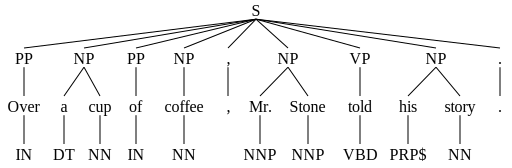

In [4]:
display(sent)
#sent.pretty_print(unicodelines=True)

---
## 2. RegExp-Chunk-Parser

In [5]:
sent = [("Rapunzel", "NNP"), ("let", "VBD"), ("down", "RP"), ("her", "PP$"), ("long", "JJ"), ("golden", "JJ"), ("hair", "NN")]

### 2.1 NP-Chunk-Parser

#### Angabe von POS-Tag-Pattern-Regeln für Chunks 

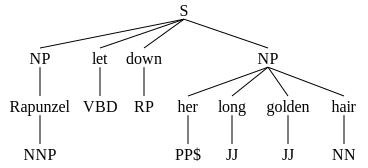

In [6]:
grammar = r"""
NP: {<DT|PP\$>?<JJ>*<NN>}  #chunk DET/POSS ADJ NOUN    
{<NN.?>+}                  #chunk sequences of NOUNS/PROPER NOUNS
"""

parser = nltk.RegexpParser(grammar)
tree = parser.parse(sent)
tree

---
### 2.2 invertierte Regelreihenfolge
##### Reihenfolge der Regelanwendung relevant!

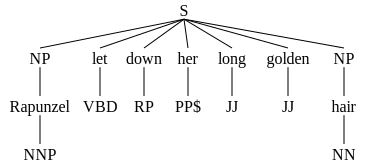

In [7]:
grammar = r"""
NP: {<NN.?>+}          #chunk sequences of NOUNS/PROPER NOUNS
{<DT|PP\$>?<JJ>*<NN>}  #chunk DET/POSS ADJ NOUN    
"""

parser = nltk.RegexpParser(grammar)
tree = parser.parse(sent)
tree

---
## 3. Chinking und Splitting

### 3.1 Chunking mit anschließendem Chinking


In [8]:
sent = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),("dog", "NN"), ("barked", "VBD"), ("at", "IN"),  ("the", "DT"), ("cat", "NN")]

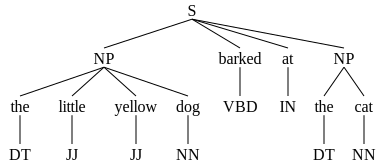

In [9]:
grammar = r"""
  NP:
    {<.*>+}      # Chunk everything
    }<VBD|IN>+{  # Chink sequences of VBD and IN
  """

parser = nltk.RegexpParser(grammar)
tree = parser.parse(sent) 
tree

---

### 3.2 Split-Regeln

In [10]:
sent = [("the", "DT"), ("cat", "NN"),("the", "DT"), ("dog", "NN"),("chased", "V")]

#### 3.2.1 ohne Split-Regel:

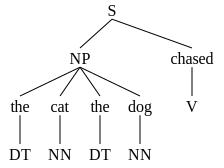

In [11]:
grammar = r"""
  NP: {<DT|NN>+}  #chunk sequences of DETs and NOUNs         
  """
  
parser = nltk.RegexpParser(grammar)
tree = parser.parse(sent) 
tree

#### 3.2.2 mit Split-Regel:

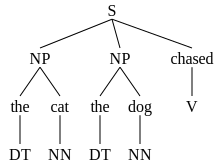

In [12]:
grammar = r"""
  NP: {<DT|NN>+}  #chunk sequences of DETs and NOUNs      
  <.*>}{<DT>      #split chunks
  """
parser = nltk.RegexpParser(grammar)
tree = parser.parse(sent) 
tree

---
## 4. Kaskadierende Chunk-Parser

### 4.1 Hintereinandergeschaltete Chunk-Parser

- **Chunk-Tags in Tag-Pattern**

#### Beispiel: Analyse hierarchischer PP-Struktur
##### kaskadierende Regeln: Output der NP-Regel als Input für folgende Regel

In [13]:
sent = [("I", "PRON"), ("shot", "V"), ("an", "DET"), ("elephant", "N"), ("in", "P"), ("my", "DET"), ("pajamas", "N")]

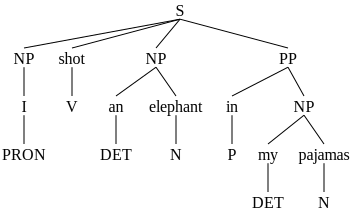

In [14]:
grammar = r"""
    NP: {<DET>?<ADJ>*<N>} 
        {<PRON>}  
    PP: {<P><NP>}
"""

parser = nltk.RegexpParser(grammar, loop=1)
tree = parser.parse(sent) 
tree

---
### 4.2 Loopen über Chunk-Grammatik

#### Loopen eines 4-stufigen Chunk-Parsers erkennt im zweiten Durchgang *(saw, VBD)* als VP eines Objektsatzes

In [15]:
sent = [("John", "NNP"), ("thinks", "VBZ"), ("Mary", "NN"), ("saw", "VBD"), ("the", "DT"), ("cat", "NN"), ("sit", "VB"), ("on", "IN"), ("the", "DT"), ("mat", "NN")]

#### 4.2.1 ohne Looping:

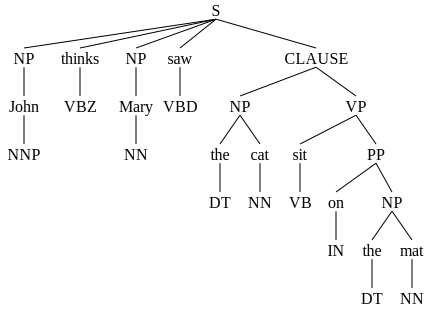

In [16]:
grammar = r"""
  NP: {<DT|JJ|NN.*>+}          # Chunk sequences of DT, JJ, NN
  PP: {<IN><NP>}               # Chunk prepositions followed by NP
  VP: {<VB.*><NP|PP|CLAUSE>+$} # Chunk verbs and their arguments
  CLAUSE: {<NP><VP>}           # Chunk NP, VP
  """

parser = nltk.RegexpParser(grammar, loop=1)
tree = parser.parse(sent)
tree

#### 4.2.2 mit Looping:

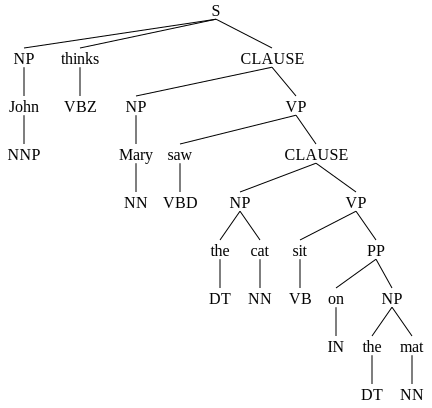

In [17]:
parser = nltk.RegexpParser(grammar, loop=2)
tree = parser.parse(sent)
#print(tree)
tree

---
## 5. Evaluation von Chunk-Parsern 

#### Grundlage: conll2000-Chunk-Korpus, eingeschränkt auf Chunk-Typ(en) des Chunk-Parsers

In [30]:
nltk.chunk.tree2conlltags(conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99])

[('Over', 'IN', 'O'),
 ('a', 'DT', 'B-NP'),
 ('cup', 'NN', 'I-NP'),
 ('of', 'IN', 'O'),
 ('coffee', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('Mr.', 'NNP', 'B-NP'),
 ('Stone', 'NNP', 'I-NP'),
 ('told', 'VBD', 'O'),
 ('his', 'PRP$', 'B-NP'),
 ('story', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [31]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
grammar = "NP: {<DT>?<JJ>*<NN>}" 
parser = nltk.RegexpParser(grammar) 
print(parser.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  59.7%%
    Precision:     45.3%%
    Recall:        24.2%%
    F-Measure:     31.6%%


In [32]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
grammar = """NP: {<DT>?<JJ>*<NN>} 
{<NN.?>+}"""
parser = nltk.RegexpParser(grammar) 
print(parser.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  69.6%%
    Precision:     43.5%%
    Recall:        43.8%%
    F-Measure:     43.6%%


--- 
## 6. Training eines datenbasierten IOB-Chunk-Tagger für PPs


In [33]:
nltk.chunk.tree2conlltags(conll2000.chunked_sents('train.txt', chunk_types=['PP'])[1])

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'O'),
 ('Exchequer', 'NNP', 'O'),
 ('Nigel', 'NNP', 'O'),
 ('Lawson', 'NNP', 'O'),
 ("'s", 'POS', 'O'),
 ('restated', 'VBN', 'O'),
 ('commitment', 'NN', 'O'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'O'),
 ('firm', 'NN', 'O'),
 ('monetary', 'JJ', 'O'),
 ('policy', 'NN', 'O'),
 ('has', 'VBZ', 'O'),
 ('helped', 'VBN', 'O'),
 ('to', 'TO', 'O'),
 ('prevent', 'VB', 'O'),
 ('a', 'DT', 'O'),
 ('freefall', 'NN', 'O'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'O'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'O'),
 ('past', 'JJ', 'O'),
 ('week', 'NN', 'O'),
 ('.', '.', 'O')]

### Unigram-Tagger


siehe https://www.nltk.org/book/ch07.html#simple-evaluation-and-baselines


#### Chunker, der für jedes POS-Tag das wahrscheinlichste Chunk-Tag berechnet (Training) und dieses dann zur Testzeit ausgibt:

In [34]:
#https://www.nltk.org/book/pylisting/code_unigram_chunker.py
    
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [
            [
                (t,c)
                for w,t,c in nltk.chunk.tree2conlltags(sent)
            ]
            for sent in train_sents
        ]
        self.tagger = nltk.UnigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [
            chunktag for (pos, chunktag) in tagged_pos_tags
        ]
        conlltags = [
            (word, pos, chunktag)
            for ((word, pos), chunktag)
            in zip(sentence, chunktags)
        ]
        return nltk.chunk.conlltags2tree(conlltags)

#### Training  des UnigramChunkers auf dem CoNLL 2000 Korpus:

In [35]:
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['PP'])
uc = UnigramChunker(train_sents)

#### Um uns einen Überblick darüber zu verschaffen, was der Chunker gelernt hat, können wir ihn für jedes mögliche POS-Tag eine Vorhersage treffen lassen:


In [36]:
postags = sorted(set(pos for sent in train_sents for (word,pos) in sent.leaves()))
uc.tagger.tag(postags)

[('#', 'O'),
 ('$', 'O'),
 ("''", 'O'),
 ('(', 'O'),
 (')', 'O'),
 (',', 'O'),
 ('.', 'O'),
 (':', 'O'),
 ('CC', 'O'),
 ('CD', 'O'),
 ('DT', 'O'),
 ('EX', 'O'),
 ('FW', 'O'),
 ('IN', 'B-PP'),
 ('JJ', 'O'),
 ('JJR', 'O'),
 ('JJS', 'O'),
 ('MD', 'O'),
 ('NN', 'O'),
 ('NNP', 'O'),
 ('NNPS', 'O'),
 ('NNS', 'O'),
 ('PDT', 'O'),
 ('POS', 'O'),
 ('PRP', 'O'),
 ('PRP$', 'O'),
 ('RB', 'O'),
 ('RBR', 'O'),
 ('RBS', 'O'),
 ('RP', 'O'),
 ('SYM', 'O'),
 ('TO', 'O'),
 ('UH', 'O'),
 ('VB', 'O'),
 ('VBD', 'O'),
 ('VBG', 'O'),
 ('VBN', 'O'),
 ('VBP', 'O'),
 ('VBZ', 'O'),
 ('WDT', 'O'),
 ('WP', 'O'),
 ('WP$', 'O'),
 ('WRB', 'O'),
 ('``', 'O')]

#### Evaluation des UnigramChunkers:

In [37]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['PP'])
print(uc.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  96.7%%
    Precision:     81.8%%
    Recall:        86.3%%
    F-Measure:     84.0%%
